In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib
from joblib import load
import os
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
import shap
import matplotlib.pyplot as plt
from xgboost import plot_importance
from pre_process import preprocess_pipeline_df, preprocess_pipeline_df1, preprocess_pipeline_df2, preprocess_pipeline_new_pt_1_1, preprocess_pipeline_new_pt_1_2, preprocess_pipeline_new_pt, decode_and_overwrite_1_1, decode_and_overwrite_1_2, decode_and_overwrite_2, xgb_model_1_1, voting_model_1_2, xgb_model_2, highlight_broad_spectrum  

In [4]:
df = pd.read_excel('TimeOut2023_2024_combined.xlsx')

In [5]:
df_pipeline = preprocess_pipeline_df(df)

In [6]:
result1 = preprocess_pipeline_df1(df_pipeline)

✅ Accuracy: 0.8684632659608598

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.35      0.52        48
           1       0.88      0.94      0.91      2139
           2       0.84      0.73      0.78       930

    accuracy                           0.87      3117
   macro avg       0.91      0.67      0.74      3117
weighted avg       0.87      0.87      0.86      3117


📉 Confusion Matrix:
 [[  17   24    7]
 [   0 2015  124]
 [   0  255  675]]


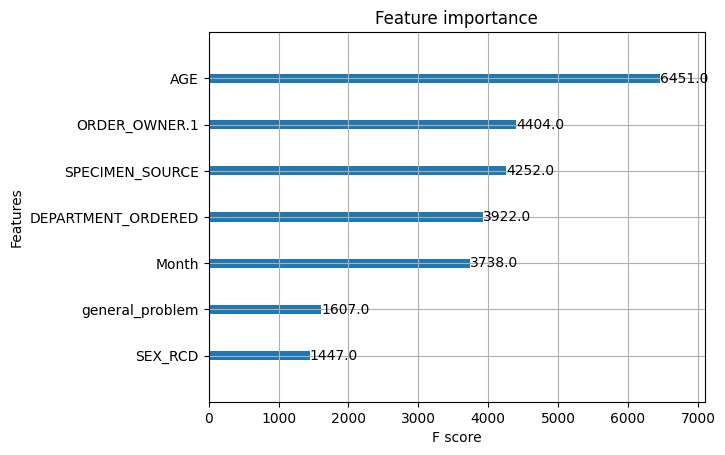

In [7]:
model, prediction_df1_1 = xgb_model_1_1(result1)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6980, number of negative: 5485
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 12465, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559968 -> initscore=0.241032
[LightGBM] [Info] Start training from score 0.241032
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6980, number of negative: 5485
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

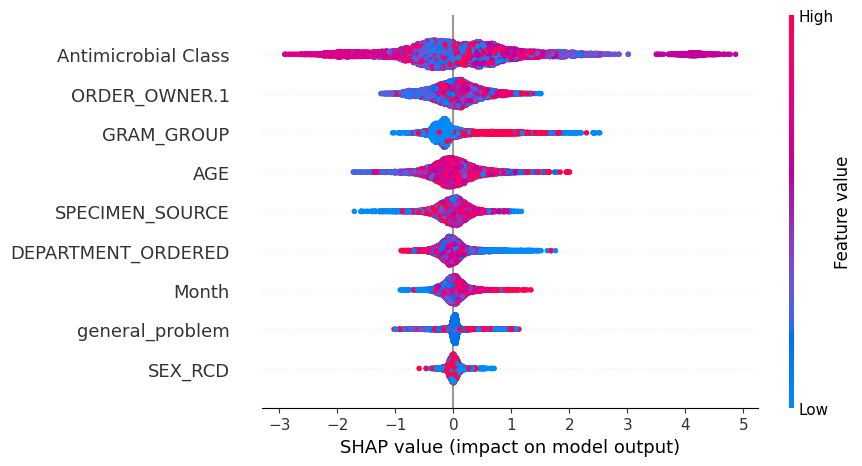

In [8]:
model, prediction_df1_2 = voting_model_1_2(result1)

In [9]:
result2 = preprocess_pipeline_df2(df_pipeline)

✅ Accuracy: 0.8910650997948144

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      2239
           1       0.90      0.91      0.91      3122

    accuracy                           0.89      5361
   macro avg       0.89      0.89      0.89      5361
weighted avg       0.89      0.89      0.89      5361


📉 Confusion Matrix:
 [[1939  300]
 [ 284 2838]]


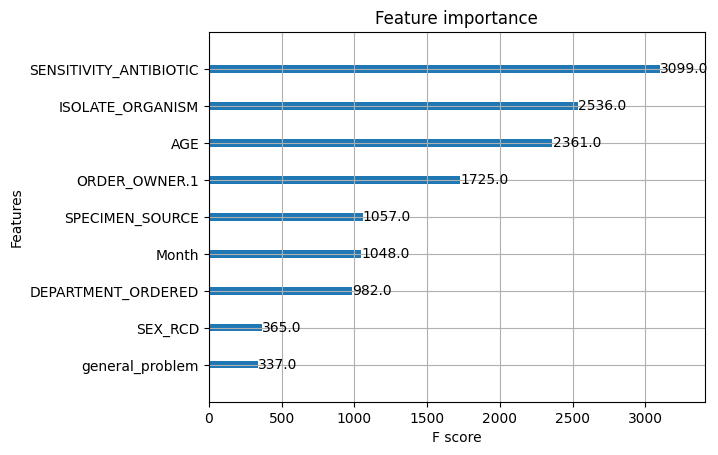

In [10]:
model, prediction_df2 = xgb_model_2(result2)

In [11]:
# Nhập thông tin bệnh nhân
new_patient_1 = {
    'VISIBLE_PATIENT_ID': [123456789],
    'SEX_RCD': ['M'],  # hoặc 'M'
    'DATE_OF_BIRTH': ['1960-05-07'],
    'ORDER_OWNER.1': ['Dr. Duong Bich Thuy'],
    'DEPARTMENT_ORDERED': ['ICU Department'],
    'PROBLEM': ['sepsis'],
    'SPECIMEN_SOURCE': ['Bile'],
    'ORDERED_DATE_TIME': ['3/23/2024']
}
# Tạo DataFrame
new_patient_1 = pd.DataFrame(new_patient_1)

In [12]:
new_patient_encoded_1_1 = preprocess_pipeline_new_pt_1_1(new_patient_1)

In [13]:
new_patient_encoded_1_1 = new_patient_encoded_1_1[['SEX_RCD', 'AGE', 'ORDER_OWNER.1', 'DEPARTMENT_ORDERED', 'general_problem', 'SPECIMEN_SOURCE', 'Month']]

In [14]:
model_gram_group = joblib.load('xgb_model_gram_group.pkl')
y_pred_1_1 = model_gram_group.predict(new_patient_encoded_1_1)
probs_1_1 = model_gram_group.predict_proba(new_patient_encoded_1_1)

In [15]:
new_patient_encoded_1_1 = decode_and_overwrite_1_1(new_patient_encoded_1_1)

In [16]:
# Load lại LabelEncoder đã dùng để encode 'GRAM PRDEDICT'
gram_encoder = joblib.load('timeout_encoders.3/GRAM_GROUP_encoder.pkl')
# Giải mã
new_patient_encoded_1_1['GRAM_GROUP'] = gram_encoder.inverse_transform(y_pred_1_1)

In [17]:
new_patient_encoded_1_1

,SEX_RCD,AGE,ORDER_OWNER.1,DEPARTMENT_ORDERED,general_problem,SPECIMEN_SOURCE,Month,GRAM_GROUP
0,M,65,Dr. Duong Bich Thuy,ICU Department,sepsis,Bile,3,Gram-negative


# dự đoán 1_2: nhạy kháng nhóm kháng sinh

In [18]:
popular_by_gram = pd.read_excel('popular_by_gram.xlsx')

In [19]:
new_patient_encoded_1_2 = preprocess_pipeline_new_pt_1_2(new_patient_encoded_1_1,popular_by_gram)

In [20]:
model_rs_1 = joblib.load('voting_model_rs_1.pkl')

In [21]:
new_patient_encoded_1_2 = new_patient_encoded_1_2[['SEX_RCD', 'AGE', 'ORDER_OWNER.1', 'DEPARTMENT_ORDERED', 'general_problem', 'SPECIMEN_SOURCE', 'GRAM_GROUP', 'Antimicrobial Class', 'Month']]

In [22]:
y_pred_1_2 = model_rs_1.predict(new_patient_encoded_1_2)
probs_1_2 = model_rs_1.predict_proba(new_patient_encoded_1_2)

In [23]:
new_patient_encoded_1_2['SENSITIVITY_INTERPRETION'] = y_pred_1_2
new_patient_encoded_1_2['PROB_SENSITIVE'] = np.round(probs_1_2[:, 1],2)  # Xác suất nhạy (class 1)

In [24]:
new_patient_encoded_1_2 = decode_and_overwrite_1_2(new_patient_encoded_1_2)

In [25]:
pt_pred_show_1_2 = new_patient_encoded_1_2[new_patient_encoded_1_2['SENSITIVITY_INTERPRETION'] == 1]

In [26]:
pt_pred_show_1_2 = pt_pred_show_1_2[['GRAM_GROUP', 'Antimicrobial Class', 'PROB_SENSITIVE']]

In [27]:
pt_pred_show_1_2 = pt_pred_show_1_2.sort_values(by=['PROB_SENSITIVE'], ascending=[False]).reset_index(drop=True)

In [28]:
pt_pred_show_1_2

,GRAM_GROUP,Antimicrobial Class,PROB_SENSITIVE
0,Gram-negative,Fosfomycins,0.92
1,Gram-negative,Lipopeptides,0.92
2,Gram-negative,Tetracyclines,0.89
3,Gram-negative,Macrolides,0.79
4,Gram-negative,Penems,0.78
5,Gram-negative,Nitroheterocyclics,0.74
6,Gram-negative,Folate pathway antagonists,0.65
7,Gram-negative,Monobactams,0.65
8,Gram-negative,Aminoglycosides,0.63
9,Gram-negative,β-lactam combination agents,0.61


## giai đoạn 2: nhạy kháng sensitive atb

In [29]:
# Danh sách từng trường hợp vi sinh vật với thông tin khác nhau
pt_data = [
    {
        'ISOLATE_ORGANISM': 'Klebsiella pneumoniae',
        'ORDER_OWNER.1': 'Dr. Vu Ngoc Chuc',
        'DEPARTMENT_ORDERED': 'Medical Ward East ',
        'PROBLEM': '',
        'SPECIMEN_SOURCE': 'Set 1 Aerobic Bottle',
        'ORDERED_DATE_TIME': '3/23/2024'
    },
    {
        'ISOLATE_ORGANISM': 'Enterococcus faecalis',
        'ORDER_OWNER.1': 'Dr. Ho An Toan',
        'DEPARTMENT_ORDERED': 'ICU Department',
        'PROBLEM': 'pneumonia',
        'SPECIMEN_SOURCE': 'Fluid',
        'ORDERED_DATE_TIME': '4/22/2024'
    },
    {
        'ISOLATE_ORGANISM': 'Enterococcus faecium',
        'ORDER_OWNER.1': 'Dr. Duong Bich Thuy',
        'DEPARTMENT_ORDERED': 'Medical Ward East ',
        'PROBLEM': '',
        'SPECIMEN_SOURCE': 'Blood Cult. Aerobic',
        'ORDERED_DATE_TIME': '4/12/2024'
    }
]

# Thông tin chung của bệnh nhân
common_info = {
    'VISIBLE_PATIENT_ID': 123456789,
    'SEX_RCD': 'M',
    'DATE_OF_BIRTH': '1/4/1954'
}

# Tạo DataFrame
new_patient = pd.DataFrame([{**common_info, **org} for org in pt_data])

In [30]:
popular_by_organism = pd.read_excel('popular_by_organism.xlsx')

In [31]:
new_patient_encoded = preprocess_pipeline_new_pt(new_patient, popular_by_organism)

In [32]:
new_patient_encoded = new_patient_encoded[['SEX_RCD', 'AGE', 'ORDER_OWNER.1', 'DEPARTMENT_ORDERED', 'general_problem', 'SPECIMEN_SOURCE', 'ISOLATE_ORGANISM', 'SENSITIVITY_ANTIBIOTIC', 'Month']]

In [33]:
model_rs_2 = joblib.load('xgb_model_rs_2.pkl')

In [34]:
y_pred = model_rs_2.predict(new_patient_encoded)
probs = model_rs_2.predict_proba(new_patient_encoded)

In [35]:
new_patient_encoded['SENSITIVITY_INTERPRETION'] = y_pred
new_patient_encoded['PROB_SENSITIVE'] = np.round(probs[:, 1],2)  # Xác suất nhạy (class 1)

In [36]:
new_patient_encoded = decode_and_overwrite_2(new_patient_encoded)

In [37]:
pt_pred_show = new_patient_encoded[new_patient_encoded['SENSITIVITY_INTERPRETION'] == 1]

In [38]:
pt_pred_show = pt_pred_show[['ISOLATE_ORGANISM', 'SENSITIVITY_ANTIBIOTIC', 'PROB_SENSITIVE']]

In [39]:
pt_pred_show = pt_pred_show.sort_values(
    by=['ISOLATE_ORGANISM', 'PROB_SENSITIVE'], ascending=[True, False]).reset_index(drop=True)

In [40]:
# Áp dụng style
pt_pred_show = pt_pred_show.style.applymap(highlight_broad_spectrum, subset=['SENSITIVITY_ANTIBIOTIC'])

In [41]:
pt_pred_show

,ISOLATE_ORGANISM,SENSITIVITY_ANTIBIOTIC,PROB_SENSITIVE
0,Enterococcus faecalis,tigecycline,0.990000
1,Enterococcus faecalis,linezolid,0.950000
2,Enterococcus faecium,tigecycline,0.980000
3,Enterococcus faecium,linezolid,0.930000
4,Enterococcus faecium,quinupristin;dalfopristin,0.710000
5,Klebsiella pneumoniae,amikacin sulfate,1.000000
6,Klebsiella pneumoniae,ertapenem,0.990000
7,Klebsiella pneumoniae,tobramycin,0.980000
8,Klebsiella pneumoniae,gentamicin,0.970000
9,Klebsiella pneumoniae,meropenem,0.970000
